In [3]:
pip install tsai -q

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tsai.all import *
from fastai.callback.all import *
import gc
import notebookcfa27bdb31 as ArrayGenerator

In [5]:
df = pd.read_pickle(
    "/kaggle/input/vhr-graduation-project-all/vhr_graduation_project_all.pickle"
)

In [6]:
raw_X = np.array(df["ts"].to_list())
raw_y = np.array(df["status"])

In [7]:
X, y = ArrayGenerator.generate_dataset_array(
    dataset_category=8, ts=raw_X, labels=raw_y, split_method="machine"
)

{'Faults classified': 'Status', 'Channels taken': 'All', 'Labels array': 'multiclass'}


In [8]:
splits = get_splits(y, valid_size=0.2, shuffle=True, show_plot=False)

In [9]:
X_train, y_train = X[splits[0]], y[splits[0]]
X_test, y_test = X[splits[1]], y[splits[1]]

#  reduced overlapping percentage to prevent the data from being
X_train, y_train = ArrayGenerator.apply_sliding_window(
    X_train, y_train, window_size=4096, with_fft=1, overlap_pct=0.6
)
X_test, y_test = ArrayGenerator.apply_sliding_window(
    X_test, y_test, window_size=4096, with_fft=1, overlap_pct=0
)

In [10]:
X_train.shape, X_test.shape  # 2048 because of the  FFT

((1446, 6, 2048), (206, 6, 2048))

In [11]:
train_balance_splits = get_splits(
    y_train,
    valid_size=0,
    balance=True,
    strategy="oversample",
    shuffle=True,
    show_plot=False,
)
X_train, y_train = X_train[train_balance_splits[0]], y_train[train_balance_splits[0]]
X, y, splits = combine_split_data([X_train, X_test], [y_train, y_test])

valid == train


In [12]:
dls = get_ts_dls(
    X,
    y,
    splits=splits,
    tfms=[None, TSClassification()],
    batch_tfms=TSStandardize(),
    bs=[16, 32],
)

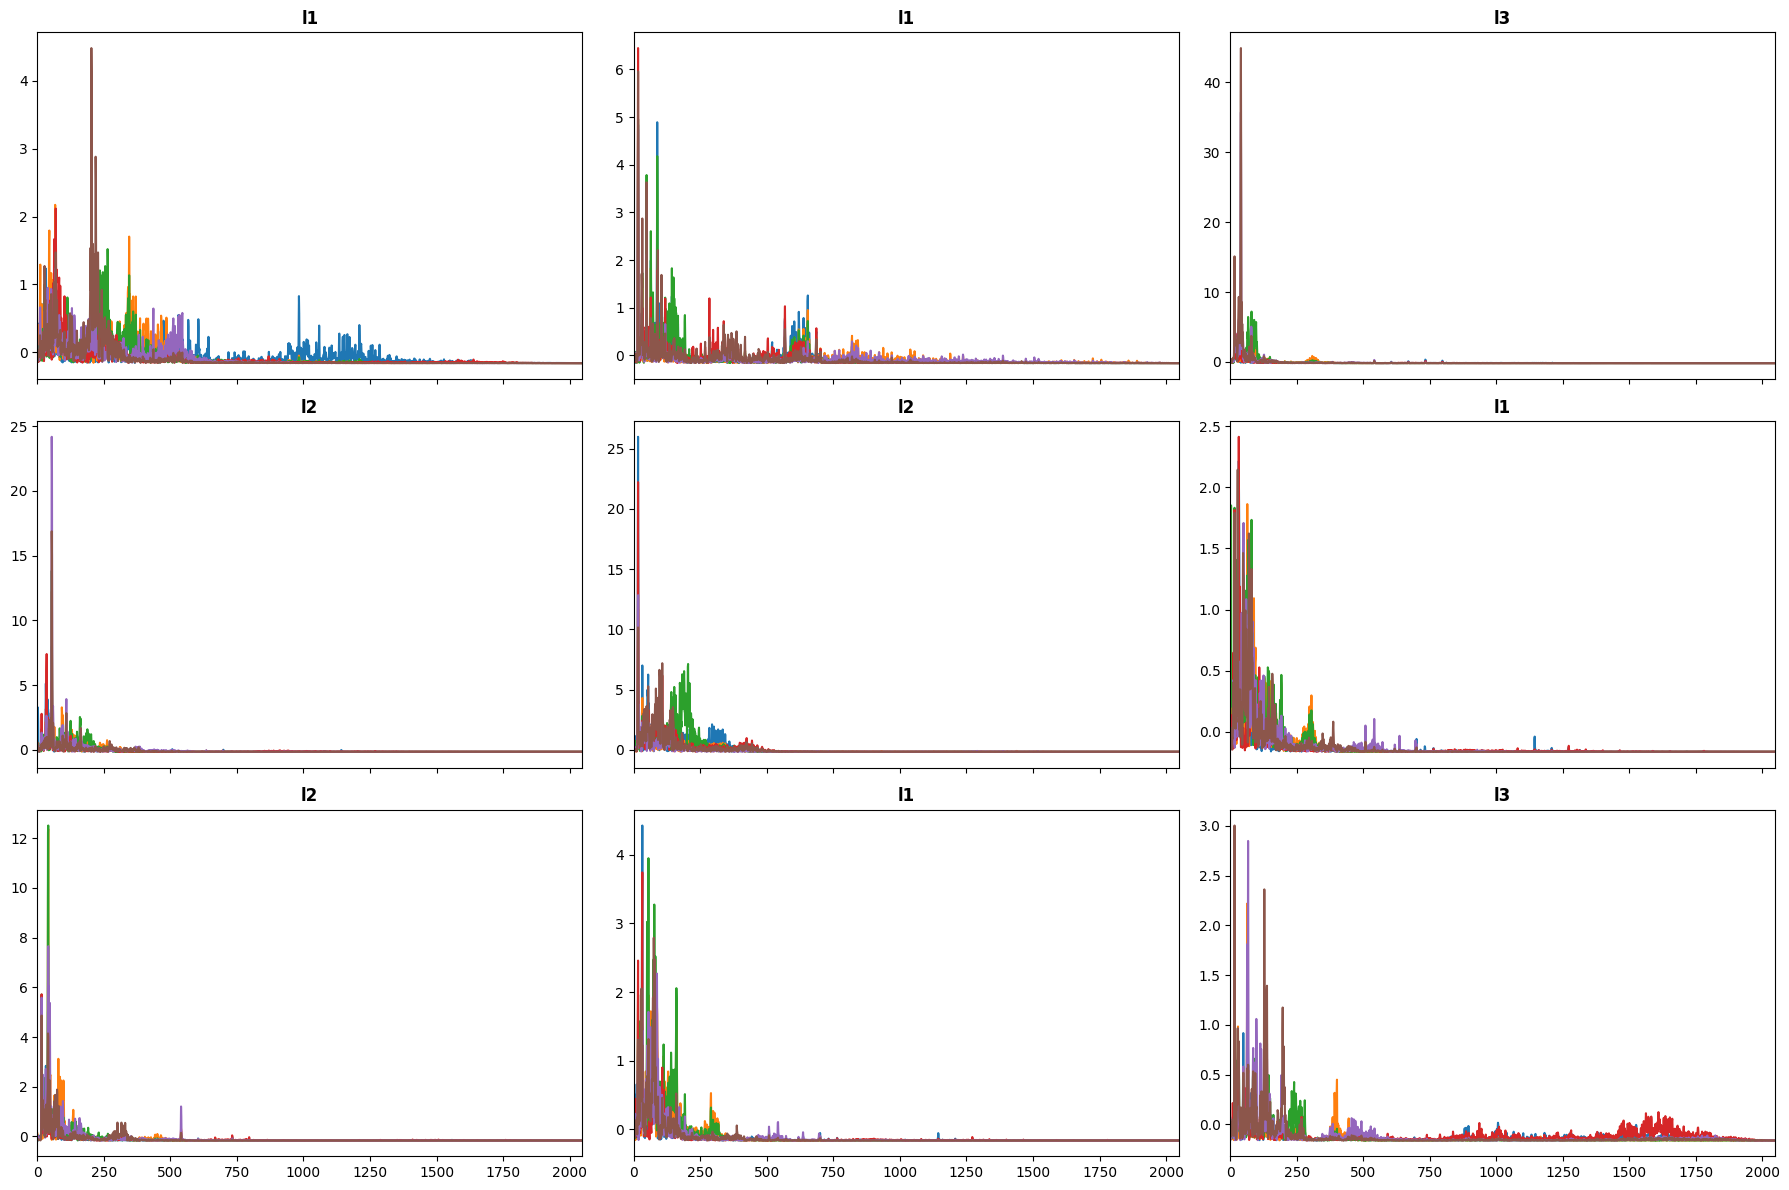

In [13]:
dls.show_batch()

In [65]:
callbacks = [
    PredictionDynamics(),
    #     EarlyStoppingCallback(monitor='f1_score', comp=np.greater , patience=5),
    #     Stopped Early stopping because sometime it stopped too early ,
    #     but it maybe the reason for the increasing valid loss
    SaveModelCallback(monitor="f1_score", comp=np.greater),
    ShowGraph(),
]

In [66]:
model = build_ts_model(LSTM_FCNPlus, dls=dls)  # trying different models
learn = Learner(
    dls,
    model,
    metrics=[
        accuracy,
        Precision(average="weighted"),
        Recall(average="weighted"),
        F1Score(average="weighted"),
        BalancedAccuracy(),
    ],
)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,balanced_accuracy_score,time
0,1.246323,1.233342,0.470874,0.668779,0.470874,0.477837,0.605747,00:02
1,0.998335,1.053862,0.548544,0.631627,0.548544,0.558312,0.626548,00:02
2,0.768331,0.924412,0.563107,0.605947,0.563107,0.559908,0.475503,00:02
3,0.606547,0.979143,0.538835,0.605523,0.538835,0.553527,0.503222,00:02
4,0.511317,0.913710,0.601942,0.663893,0.601942,0.613960,0.549268,00:02
5,0.471341,0.936728,0.650485,0.689559,0.650485,0.653108,0.545527,00:02
6,0.405340,0.976956,0.621359,0.667762,0.621359,0.629621,0.538322,00:02
7,0.314147,0.909077,0.694175,0.700033,0.694175,0.693925,0.559979,00:02
8,0.282037,0.989655,0.684466,0.696816,0.684466,0.684642,0.516825,00:02
9,0.247307,1.071293,0.650485,0.697508,0.650485,0.655398,0.545469,00:02


Better model found at epoch 0 with f1_score value: 0.4778370496817098.


,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,balanced_accuracy_score
24,0.011826,1.469158,0.757282,0.752991,0.757282,0.752603,0.603671


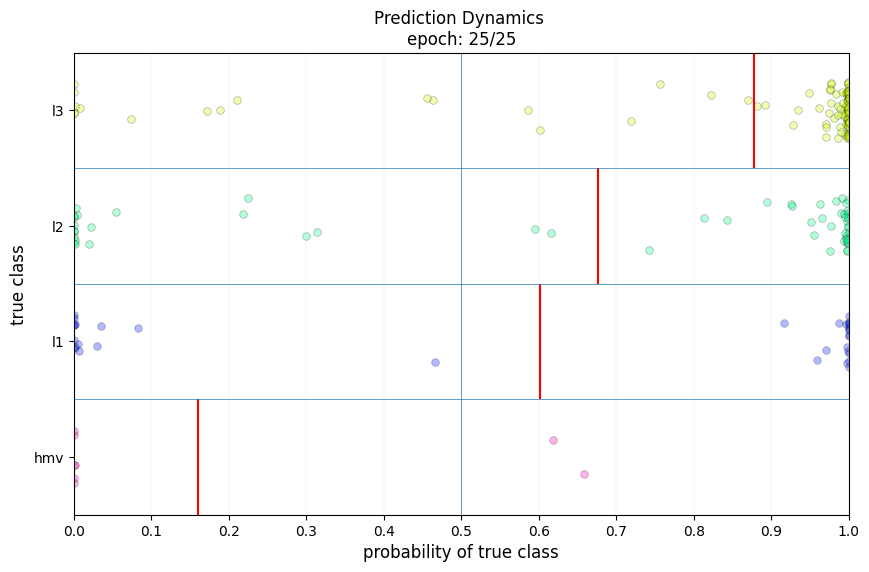

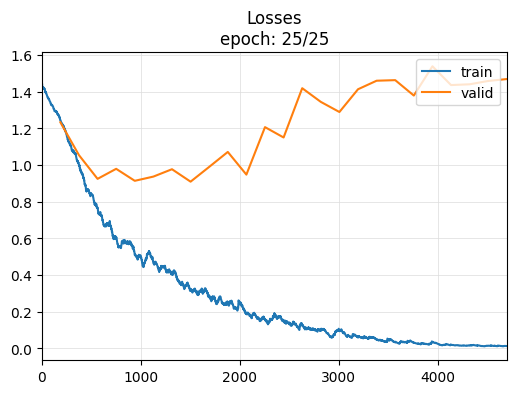

Better model found at epoch 1 with f1_score value: 0.5583120613795861.
Better model found at epoch 2 with f1_score value: 0.5599082723806361.
Better model found at epoch 4 with f1_score value: 0.6139600835945915.
Better model found at epoch 5 with f1_score value: 0.6531079351678761.
Better model found at epoch 7 with f1_score value: 0.6939248409800041.
Better model found at epoch 10 with f1_score value: 0.7114211940269646.
Better model found at epoch 11 with f1_score value: 0.720522284721842.
Better model found at epoch 19 with f1_score value: 0.7523389292107561.
Better model found at epoch 21 with f1_score value: 0.7581010848331656.
Better model found at epoch 23 with f1_score value: 0.7662972862696366.


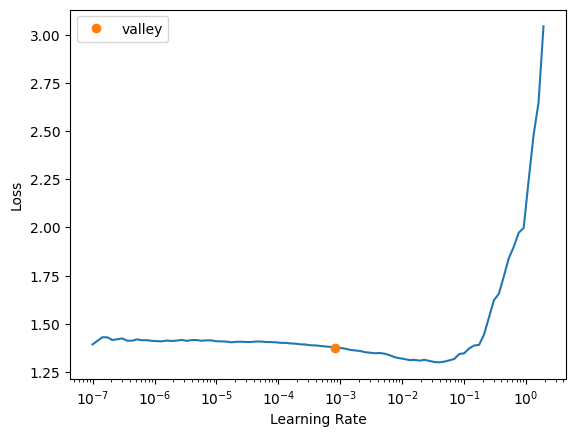

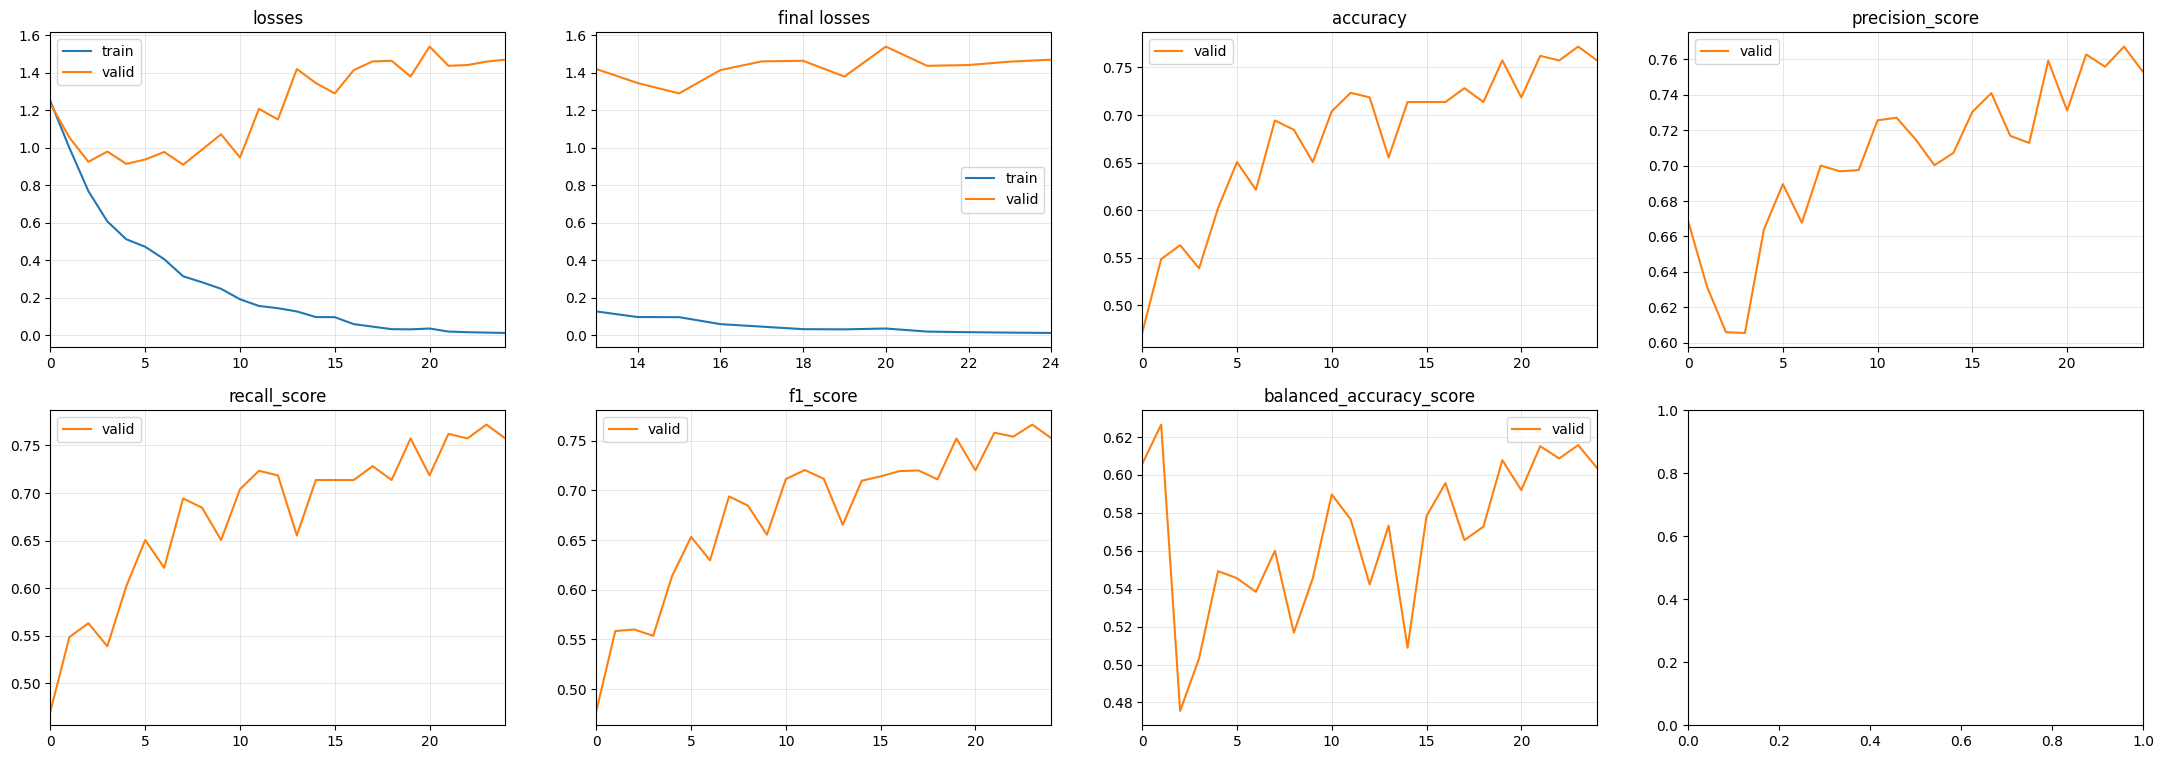

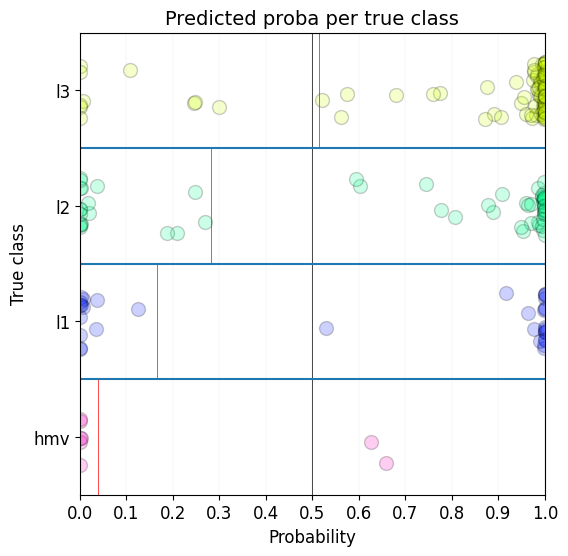

              precision    recall  f1-score   support

         hmv       0.50      0.25      0.33         8
          l1       0.57      0.62      0.59        34
          l2       0.78      0.69      0.73        58
          l3       0.84      0.91      0.87       106

    accuracy                           0.77       206
   macro avg       0.67      0.62      0.63       206
weighted avg       0.77      0.77      0.77       206



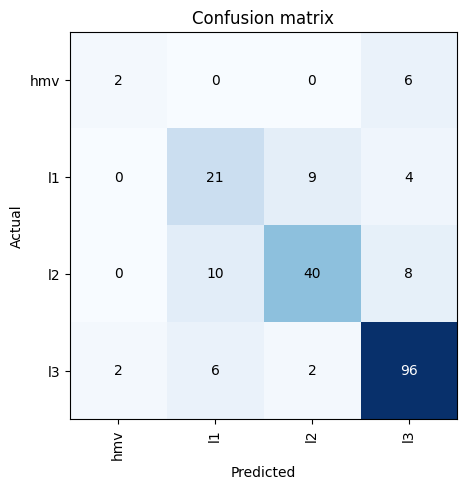

In [67]:
learn.fit_one_cycle(25, lr_max=learn.lr_find(), cbs=callbacks)
learn.show_probas()
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.print_classification_report()

# Some comments on the results

* is an increasing validation loss a clear indicator of overfitting on the training data?

* metrics for each class alone is above the confusion matrix, found a function for that :)

In [68]:
interp.most_confused()

[('l2', 'l1', 10),
 ('l1', 'l2', 9),
 ('l2', 'l3', 8),
 ('hmv', 'l3', 6),
 ('l3', 'l1', 6),
 ('l1', 'l3', 4),
 ('l3', 'hmv', 2),
 ('l3', 'l2', 2)]

# After a small research on the difference between averages in multiclass metrics, this is what I got to

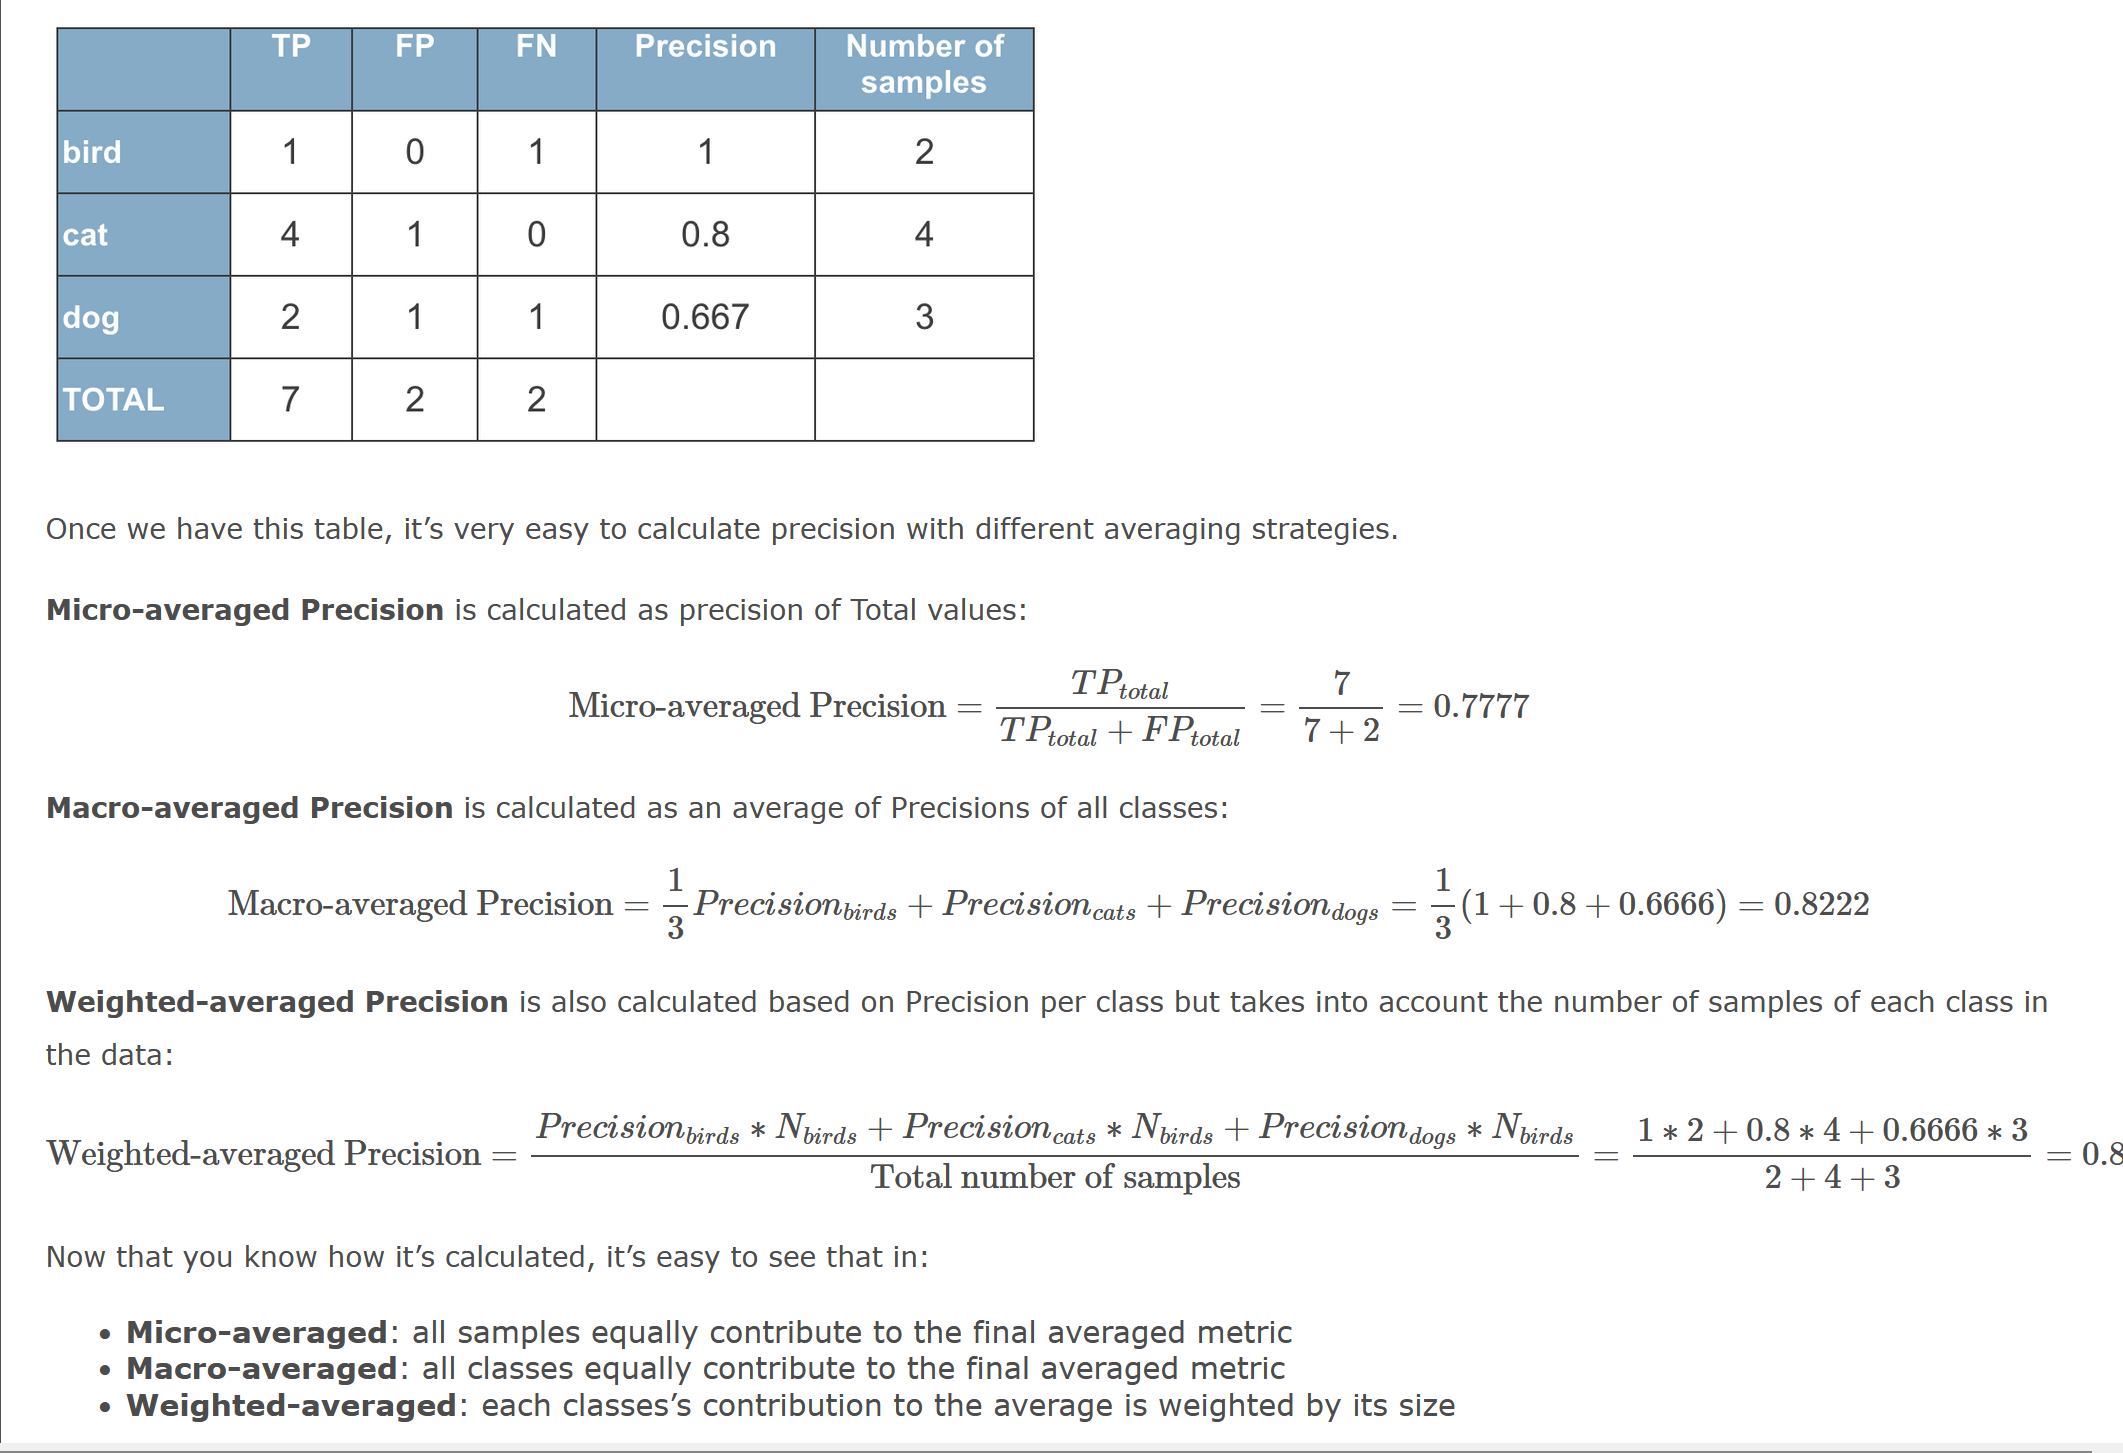

# We have class imbalance , so it's better to use weighted-average.That's why I used it in the Learner's metrics